# Import libraries

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import muon as mu

/home/chayan/anaconda3/envs/umint/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pysam
import hdf5plugin
import os

In [3]:
mu.set_options(display_style = "html", display_html_expand = 0b000)

# Load ATAC data

In [4]:
# This is the directory where those files are downloaded to
data_dir = "/home/chayan/UMINT/pbmc10k/"

In [5]:
# Remove file prefixes if any
#prefix = "pbmc_granulocyte_sorted_10k_"
#for file in os.listdir(data_dir):
#    if file.startswith(prefix):
#        new_filename = file[len(prefix):]
#        os.rename(os.path.join(data_dir, file), os.path.join(data_dir, new_filename))

In [6]:
mdata = mu.read(data_dir+"pbmc10k.h5mu")
mdata

#mdata = mu.read_10x_h5(os.path.join(data_dir, "filtered_feature_bc_matrix.h5"))
#mdata.var_names_make_unique()
#mdata

MuData object with n_obs × n_vars = 11909 × 134726
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	10887 x 26349
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'
    atac:	11909 x 108377
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'atac', 'files'

In [7]:
from muon import atac as ac

In [8]:
atac = mdata.mod['atac']
atac  # an AnnData object

AnnData object with n_obs × n_vars = 11909 × 108377
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
    uns: 'atac', 'files'

# Preprocessing ATAC

QC

In [9]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

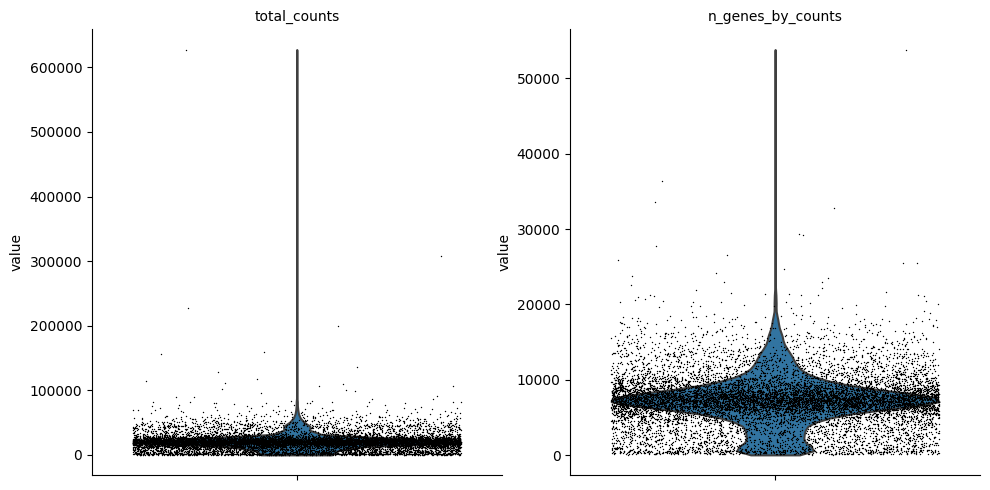

In [10]:
sc.pl.violin(atac, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)

Filter peaks by expression values

In [11]:
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)
# This is analogous to
#   sc.pp.filter_genes(rna, min_cells=10)
# but does in-place filtering and avoids copying the object

Filter cells

In [12]:
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 2000) & (x <= 15000))
# This is analogous to
#   sc.pp.filter_cells(atac, max_genes=15000)
#   sc.pp.filter_cells(atac, min_genes=2000)
# but does in-place filtering avoiding copying the object

mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 4000) & (x <= 40000))

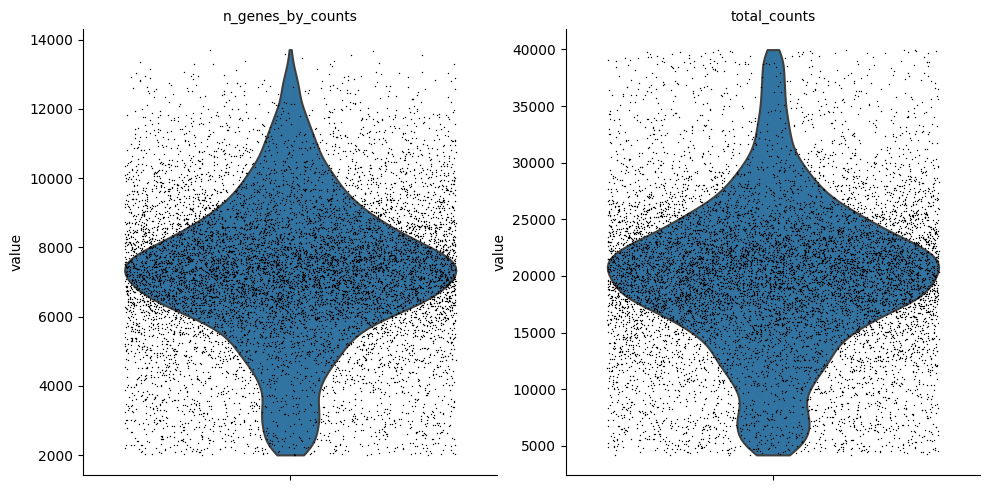

In [13]:
sc.pl.violin(atac, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

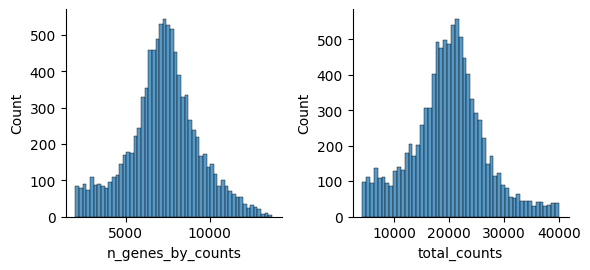

In [14]:
mu.pl.histogram(atac, ['n_genes_by_counts', 'total_counts'])

ATAC-specific QC

There are a few expectations about how ATAC-seq data looks like as noted in the hitchhiker’s guide to ATAC-seq data analysis for instance.

Nucleosome signal

Fragment size distribution typically reflects nucleosome binding pattern showing enrichment around values corresponding to fragments bound to a single nucleosome (between 147 bp and 294 bp) as well as nucleosome-free fragments (shorter than 147 bp).

In [15]:
atac.obs['NS']=1

[W::hts_idx_load2] The index file is older than the data file: /home/chayan/UMINT/pbmc10k/atac_fragments.tsv.gz.tbi
Fetching Regions...: 100%|████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


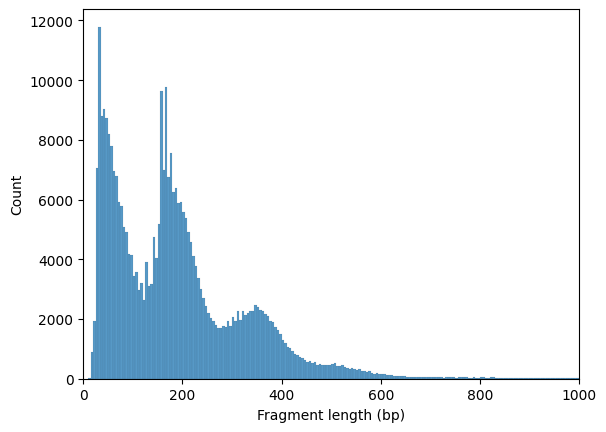

In [16]:
ac.pl.fragment_histogram(atac, region='chr1:1-2000000')

In [17]:
ac.tl.nucleosome_signal(atac, n=1e6)

[W::hts_idx_load2] The index file is older than the data file: /home/chayan/UMINT/pbmc10k/atac_fragments.tsv.gz.tbi
Reading Fragments: 100%|██████████| 1000000/1000000 [00:02<00:00, 399499.30it/s]


TSS enrichment

We can expect chromatin accessibility enriched around transcription start sites (TSS) compared to accessibility of flanking regions. Thus this measure averaged across multiple genes can serve as one more quality control metric.

The positions of transcription start sites can be obtained from the interval field of the gene annotation in the rna modality:

In [18]:
ac.tl.get_gene_annotation_from_rna(mdata['rna']).head(3)  # accepts MuData with 'rna' modality or mdata['rna'] AnnData directly

,Chromosome,Start,End,gene_id,gene_name
AL627309.1,chr1,120931,133723,ENSG00000238009,AL627309.1
AL627309.5,chr1,149706,173862,ENSG00000241860,AL627309.5
AL627309.4,chr1,160445,160446,ENSG00000241599,AL627309.4


TSS enrichment function will return an AnnData object with cells x bases dimensions where bases correspond to positions around TSS and are defined by extend_upstream and extend_downstream parameters, each of them being 1000 bp by default. It will also record tss_score in the original object.

In [19]:
tss = ac.tl.tss_enrichment(mdata, n_tss=1000)  # by default, features=ac.tl.get_gene_annotation_from_rna(mdata)

[W::hts_idx_load2] The index file is older than the data file: /home/chayan/UMINT/pbmc10k/atac_fragments.tsv.gz.tbi
Fetching Regions...: 100%|██████████████████| 1000/1000 [00:24<00:00, 41.40it/s]


In [20]:
tss

AnnData object with n_obs × n_vars = 10069 × 2001
    obs: 'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'tss_score'
    var: 'TSS_position'

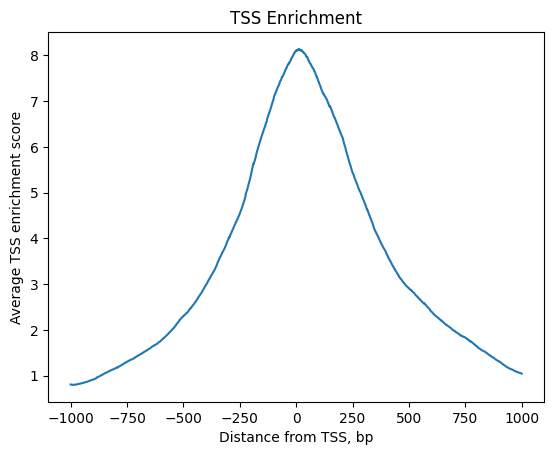

In [21]:
ac.pl.tss_enrichment(tss)

Normalization

In [22]:
# Save original counts
atac.layers["counts"] = atac.X

TF-IDF

In [23]:
ac.pp.tfidf(atac, scale_factor=1e4)

In [24]:
sc.pp.normalize_per_cell(atac, counts_per_cell_after=1e4)
sc.pp.log1p(atac)

Feature Selection

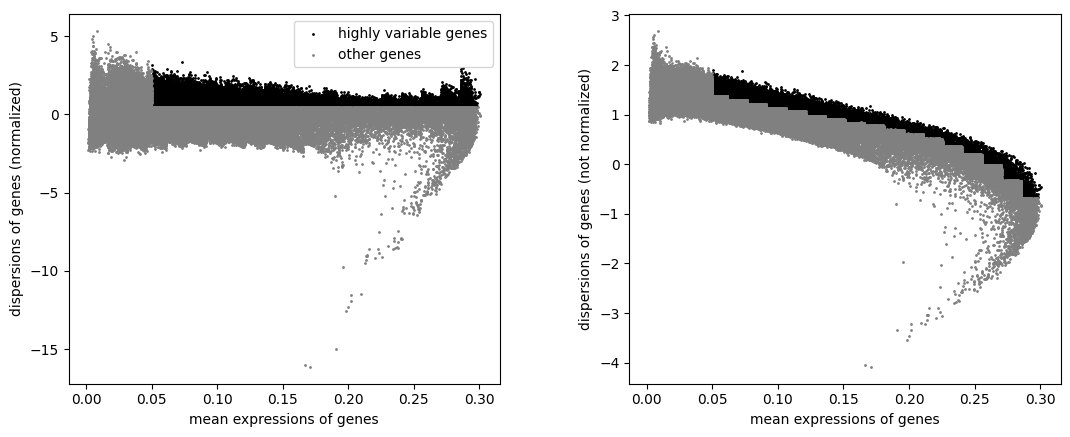

In [25]:
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=.5)
sc.pl.highly_variable_genes(atac)

In [26]:
np.sum(atac.var.highly_variable)

19430

Scaling

In [27]:
atac.raw = atac

Analysis

LSI

In [28]:
ac.tl.lsi(atac)

We find the first component is typically associated with number of peaks or counts per cell so it is reasonable to remove it:

In [29]:
atac.obsm['X_lsi'] = atac.obsm['X_lsi'][:,1:]
atac.varm["LSI"] = atac.varm["LSI"][:,1:]
atac.uns["lsi"]["stdev"] = atac.uns["lsi"]["stdev"][1:]

In [30]:
sc.pp.neighbors(atac, use_rep="X_lsi", n_neighbors=10, n_pcs=30)

PCA

In [31]:
sc.pp.scale(atac)
sc.tl.pca(atac)

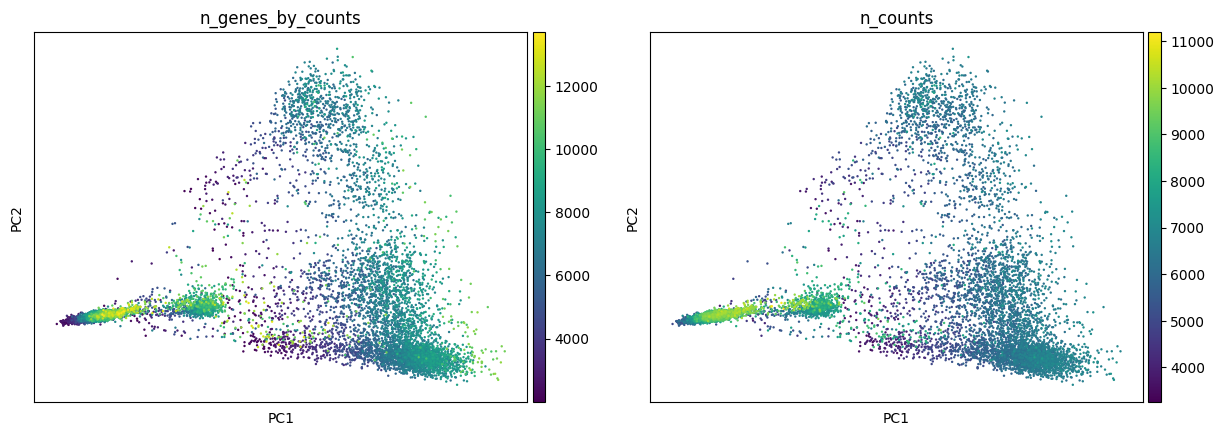

In [32]:
sc.pl.pca(atac, color=["n_genes_by_counts", "n_counts"])

In [33]:
atac.uns['atac']['peak_annotation'].tail()

,peak,distance,peak_type
gene_name,,,
AC213203.2,KI270713.1:20444-22615,9913,distal
AC213203.2,KI270713.1:27118-28927,3601,distal
AC213203.2,KI270713.1:29485-30706,1822,distal
AC213203.2,KI270713.1:31511-32072,456,distal
AC213203.1,KI270713.1:37129-37638,1723,distal


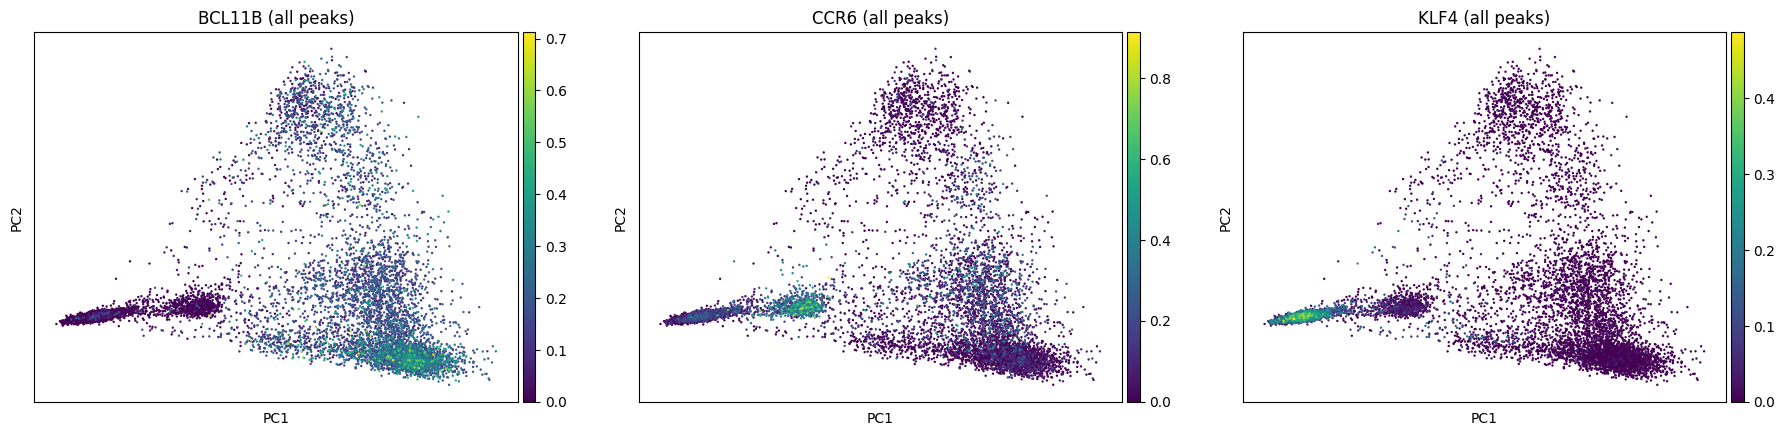

In [34]:
ac.pl.pca(atac, color=["BCL11B", "CCR6", "KLF4"], average="total")

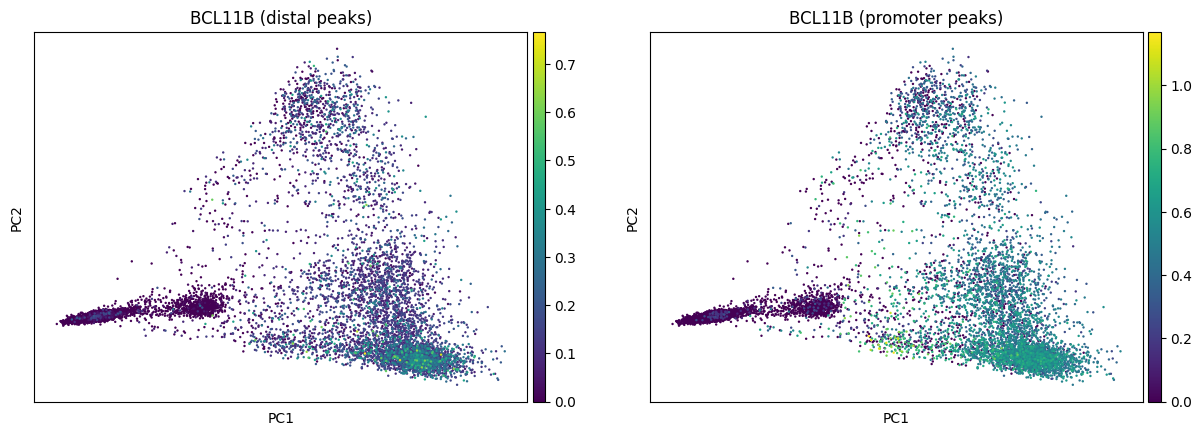

In [35]:
ac.pl.pca(atac, color="BCL11B", average="peak_type")

In [36]:
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=30)

Non-linear dimensionality reduction and clustering

In [37]:
sc.tl.leiden(atac, resolution=.5)

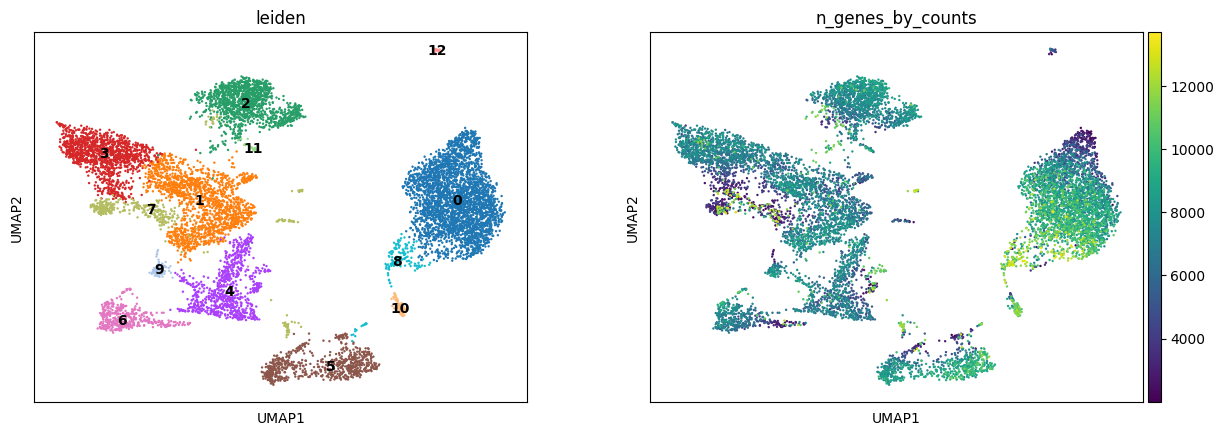

In [38]:
sc.tl.umap(atac, spread=1.5, min_dist=.5, random_state=20)
sc.pl.umap(atac, color=["leiden", "n_genes_by_counts"], legend_loc="on data")

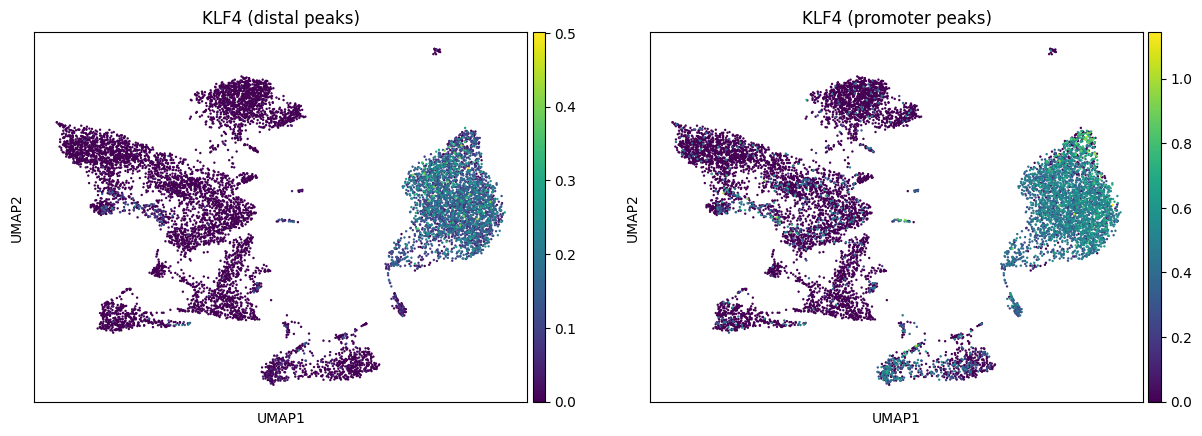

In [39]:
ac.pl.umap(atac, color=["KLF4"], average="peak_type")

Marker genes and celltypes

In [40]:
ac.tl.rank_peaks_groups(atac, 'leiden', method='t-test')

In [41]:
result = atac.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option("max_columns", 50)
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'genes', 'pvals']}).head(10)

,0_n,0_g,0_p,1_n,1_g,1_p,2_n,2_g,2_p,3_n,3_g,3_p,4_n,4_g,4_p,5_n,5_g,5_p,6_n,6_g,6_p,7_n,7_g,7_p,8_n,8_g,8_p,9_n,9_g,9_p,10_n,10_g,10_p,11_n,11_g,11_p,12_n,12_g,12_p
0,chr9:107480158-107492721,KLF4,0.0,chr14:22536559-22563070,"TRAJ7, TRAJ6, TRAJ5, TRAJ4, TRAJ3, TRAJ2, TRAJ...",2.706646e-315,chr2:86783559-86792275,CD8A,0.000000e+00,chr14:99255246-99275454,"BCL11B, AL109767.1",2.076950e-228,chr1:24909406-24919504,RUNX3,1.549425e-165,chr22:41917087-41929835,TNFRSF13C,7.964308e-264,chr17:83076201-83103570,"METRNL, AC130371.2",5.276720e-149,chr19:1230013-1281741,"CIRBP, ATP5F1D, CBARP, MIDN, FAM174C, CIRBP-AS...",1.721507e-20,chr1:220876295-220883526,"HLX, HLX-AS1",2.003696e-24,chr16:81519063-81525049,CMIP,5.183837e-22,chr17:81425658-81431769,BAHCC1,3.502022e-36,chr16:88448143-88480965,ZFPM1,1.019302e-11,chr10:133265906-133281093,"TUBGCP2, ADAM8",1.132848e-09
1,chr20:50269694-50277398,SMIM25,0.0,chr14:99255246-99275454,"BCL11B, AL109767.1",2.374649e-207,chr11:66311352-66319301,"CD248, AP001107.3",2.427740e-291,chr14:99223600-99254668,"BCL11B, AL109767.1",1.041560e-181,chr2:144507361-144525092,"ZEB2, LINC01412, ZEB2-AS1, AC009951.6",3.142172e-145,chr22:41931503-41942227,CENPM,1.037101e-234,chr1:24909406-24919504,RUNX3,8.662046e-100,chr19:12774552-12797715,"HOOK2, PRDX2, JUNB, AC018761.2, AC018761.3",5.175188e-13,chr18:9707302-9713342,RAB31,1.256672e-23,chr15:39623205-39625650,"FSIP1, AC037198.2",9.308879e-22,chr22:50281096-50284890,PLXNB2,5.362811e-31,chr5:35850992-35860227,IL7R,4.068810e-08,chr19:1230013-1281741,"CIRBP, ATP5F1D, CBARP, MIDN, FAM174C, CIRBP-AS...",1.917718e-09
2,chr22:38950570-38958424,APOBEC3A,0.0,chr10:8041366-8062418,"GATA3, GATA3-AS1, AL390294.1",9.487298e-201,chr14:99255246-99275454,"BCL11B, AL109767.1",5.727006e-292,chr14:99181080-99219442,"BCL11B, AL162151.1",6.100258e-164,chr4:6198055-6202103,"JAKMIP1, C4orf50",4.311201e-134,chr2:231669797-231676530,PTMA,4.130026e-215,chr2:28388837-28416648,"FOSL2, AC104695.2, AC104695.4",1.330982e-101,chr19:1061757-1096608,"ABCA7, POLR2E, ARHGAP45",1.028414e-12,chr9:107480158-107492721,KLF4,1.872095e-22,chr11:114072228-114076352,ZBTB16,2.586642e-21,chr6:4281598-4282429,AL159166.1,1.656407e-29,chr14:101807949-101830976,"PPP2R5C, AL137779.2",4.102217e-08,chr2:231704562-231718074,PTMA,2.032109e-08
3,chr1:182143071-182150314,"LINC01344, AL390856.1",0.0,chr7:142782798-142813716,"TRBC1, TRBJ2-1, TRBJ2-2, TRBJ2-2P, TRBJ2-3, TR...",1.007688e-192,chr12:10552886-10555668,LINC02446,1.238386e-231,chr7:142782798-142813716,"TRBC1, TRBJ2-1, TRBJ2-2, TRBJ2-2P, TRBJ2-3, TR...",1.418838e-151,chr2:241762278-241764383,"D2HGDH, AC114730.2",6.916892e-132,chr19:5125450-5140568,"KDM4B, AC022517.1",9.500481e-209,chr1:184386243-184389335,"C1orf21, AL445228.2",2.052636e-88,chr14:99255246-99275454,"BCL11B, AL109767.1",1.588465e-12,chr17:81044486-81052618,BAIAP2,1.206384e-21,chr17:40536232-40543738,CCR7,6.880167e-21,chr6:11730442-11733107,"ADTRP, AL022724.3",2.748878e-29,chr22:39087900-39092994,APOBEC3H,3.416514e-07,chr6:32966117-32979035,"BRD2, AL645941.1, AL645941.3",3.150639e-08
4,chr5:1476663-1483241,"SLC6A3, LPCAT1",0.0,chr14:99223600-99254668,"BCL11B, AL109767.1",2.663425e-162,chr2:136122469-136138482,CXCR4,3.429092e-258,chr14:22536559-22563070,"TRAJ7, TRAJ6, TRAJ5, TRAJ4, TRAJ3, TRAJ2, TRAJ...",1.868662e-151,chr20:24948563-24956577,CST7,2.927309e-133,chr6:167111604-167115345,"CCR6, AL121935.1",2.375920e-184,chr20:24948563-24956577,CST7,3.829519e-83,chr13:41454127-41473540,RGCC,4.376550e-11,chr3:159762787-159765472,"IQCJ-SCHIP1-AS1, IQCJ-SCHIP1",5.640858e-20,chr11:114065160-114066911,ZBTB16,9.852823e-21,chr17:16986865-16990016,LINC02090,6.711565e-29,chr4:185202045-185205006,"SNX25, CFAP97",3.689344e-07,chr19:21593423-21595308,AC123912.2,1.100002e-07
5,chr9:134369462-134387253,RXRA,0.0,chr20:59157931-59168100,ZNF831,8.580259e-152,chr14:99181080-99219442,"BCL11B, AL162151.1",1.439514e-241,chr17:82125073-82129615,CCDC57,9.227587e-138,chr4:1199596-1209141,SPON2,6.143883e-126,chr6:150598919-150601318,

Having studied markers of individual clusters, we will filter some cells out before assigning cell types names to clusters: likely doublets in clusters 10 and 14, proliferating cells in 15, stressed cells in 16.

In [42]:
#mu.pp.filter_obs(atac, "leiden", lambda x: ~x.isin(["10", "14", "15", "16"]))
mu.pp.filter_obs(atac, "leiden", lambda x: ~x.isin(["11", "12", "7"]))
# Analogous to
#   atac = atac[~atac.obs.leiden.isin(["10", "14", "15", "16"])]
# but doesn't copy the object

In [58]:
'''
new_cluster_names = {
    "1": "CD4+ memory T", "2": "CD8+ naïve T", "3": "CD4+ naïve T",
    "5": "CD8+ activated T", "8": "NK", "12": "MAIT",
    "9": "naïve B", "6": "memory B",
    "0": "intermediate mono", "4": "CD14 mono", "7": "CD16 mono",
    "11": "mDC", "13": "pDC",
}
'''
new_cluster_names = {
    "1": "CD4+ memory T", "3": "CD8+ naïve T", "2": "CD4+ naïve T",
    "4": "CD8+ activated T", "6": "NK", "9": "MAIT", "5": "memory B",
    "0": "intermediate mono", "8": "mDC", "10": "pDC",
}


atac.obs['celltype'] = atac.obs.leiden.astype("str").values
atac.obs.celltype = atac.obs.celltype.astype("category").cat.rename_categories(new_cluster_names)

In [59]:
np.unique(atac.obs.celltype)

array(['CD4+ memory T', 'CD4+ naïve T', 'CD8+ activated T',
       'CD8+ naïve T', 'MAIT', 'NK', 'intermediate mono', 'mDC',
       'memory B', 'pDC'], dtype=object)

In [60]:
atac.obs.celltype.cat.reorder_categories([
    'CD4+ naïve T', 'CD4+ memory T', 'MAIT',
    'CD8+ naïve T', 'CD8+ activated T', 'NK',
    'memory B','intermediate mono', 'mDC', 'pDC'], inplace=True)


/home/chayan/anaconda3/envs/umint/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  after removing the cwd from sys.path.


In [61]:
import matplotlib
import matplotlib.pyplot as plt

cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, len(atac.obs.celltype.cat.categories)))

atac.uns["celltype_colors"] = list(map(matplotlib.colors.to_hex, colors))

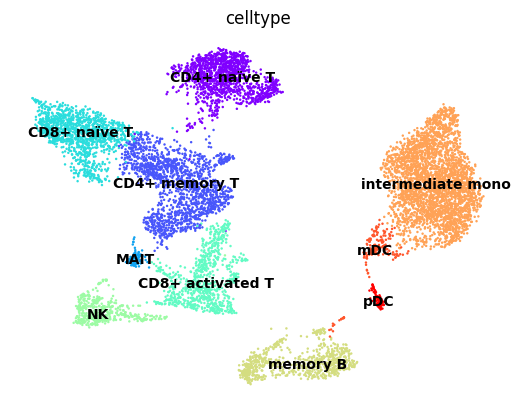

In [62]:
sc.pl.umap(atac, color="celltype", legend_loc="on data", frameon=False)

In [63]:
marker_genes = ['IL7R', 'TRAC',
                'GATA3',
                'SLC4A10',
                'CD8A', 'CD8B', 'CD248', 'CCL5',
                'GNLY', 'NKG7',
                'CD79A', 'MS4A1', 'IGHD', 'IGHM', 'TNFRSF13C',
                'IL4R', 'KLF4', 'LYZ', 'S100A8', 'ITGAM', 'CD14',
                'FCGR3A', 'MS4A7', 'CST3',
                'CLEC10A', 'IRF8', 'TCF4']

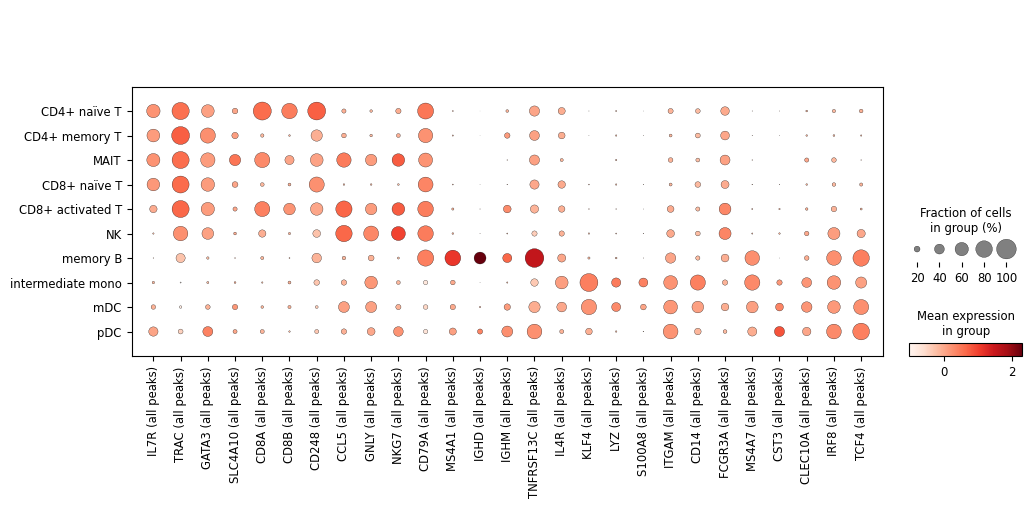

In [64]:
ac.pl.dotplot(atac, marker_genes, groupby='celltype')

**Converting the OrdereDict's to Dict**

In [65]:
temp = ['atac','files', 'neighbors']
for i in temp:
    atac.uns[i] = dict(atac.uns[i])

# Saving multimodal data on disk

In [66]:
mu.write("/home/chayan/UMINT/pbmc10k/pbmc10k.h5mu/atac", atac)

atac.write_h5ad("/home/chayan/UMINT/pbmc10k/pbmc10k_atac.h5ad")
#atac1 = sc.read_h5ad("/content/drive/MyDrive/data/pbmc10k/pbmc10k_atac.h5ad")